<a href="https://colab.research.google.com/github/davidellavalle/Social-media-and-Big-Data/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
# make plot outputs appear and be stored within the notebook
%matplotlib inline
# remove stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
# apply stemming
from nltk.stem import PorterStemmer
# Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
# split train and test
from sklearn.model_selection import train_test_split
# Regex
import re
import string
# tensorflow for creation and training of deep learning model 
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
# tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
# padding
from tensorflow.keras.preprocessing import sequence
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# First upload

# from google.colab import files
# uploaded = files.upload()

In [4]:
# create df
# encoding = convert string from UTF-8 to Latin-1
# names = assign names to columns

# import io
# df = pd.read_csv(io.BytesIO(uploaded["/content/drive/MyDrive/CAB/Data/test_data.csv"]), encoding="latin-1", names=["label", "id", "date", "flag", "username", "text"])

In [5]:
# Data saved on google drive for easy access   

from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [9]:
# import data from Drive

df = pd.read_csv("/content/gdrive/MyDrive/CAB/Data/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python",names=["label", "id", "date", "flag", "username", "text"])

In [10]:
df.head()

,label,id,date,flag,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
df.shape

(1600000, 6)

In [12]:
# data type, check on null values, count of records

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   flag      1600000 non-null  object
 4   username  1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [13]:
# data is complete

df.isnull().sum()

label       0
id          0
date        0
flag        0
username    0
text        0
dtype: int64

In [14]:
#create new df with only columns used for the training model

df = df[["label", "text"]]
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [15]:
# replace values under label with negative, neutral and positive for plotting

sent_dict = {0:"negative", 2:"neutral", 4:"positive"}
df.label = df.label.map(sent_dict)
df.head()

,label,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Label ditribution')

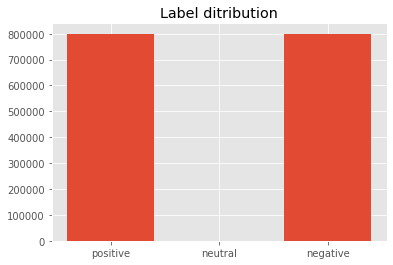

In [16]:
negative = (df.label == "negative").sum() 
neutral = (df.label == "neutral").sum()
positive = (df.label == "positive").sum()

plt.bar(["positive", "neutral","negative"],[positive, neutral,negative]) # data, height
plt.title("Label ditribution")

In [17]:
# replace value positve with 1 and negative with 0


df.label = df.label.replace({"positive":1, "negative":0})

In [22]:
df.dtypes

label     int64
text     object
dtype: object

Convert all text to lower cases

In [24]:
# Convert records to lower case

df.text = df.text.str.lower()
print(df.head())

   label                                               text
0      0  @switchfoot http://twitpic.com/2y1zl - awww, t...
1      0  is upset that he can't update his facebook by ...
2      0  @kenichan i dived many times for the ball. man...
3      0    my whole body feels itchy and like its on fire 
4      0  @nationwideclass no, it's not behaving at all....


Remove Emails, Urls and Digits

In [25]:
# removing emails
# \S matches any non-whitespace character 
# @ for as in the Email 
# + for Repeats a character one or more times 
# c

# [.\w]{3,}@[.\w]{5,}
# at least 3 characters that can include periods or word characters, 
# followed by an @ sign, followed by at least 5 characters that include word characters and periods

df.text = df.text.apply(lambda x: re.sub('\S+@\S+'," ", x))

In [26]:
# removing URLs

df.text = df.text.apply(lambda x: re.sub("((www\.[^\s]+)|(https?://[^\s]+))", " ", x))

In [27]:
# Removing digits

df.text = df.text.apply(lambda x:re.sub('[0-9]+', '', x))
# df.text = df.text.apply(lambda x:''.join(i for i in x if not i.isdigit()))

------------------------
cleaning from:  
- punctuations
- stopwords  


In [28]:
# remove punctuations
# for loop is way to slow.

# punctuations = string.punctuation

# for i in range(len(df)):
#   try:
#     for j in df.text[i]:
#       if j in punctuations:
#         df.text[i] = df.text[i].replace(j, "")
#   except:
#     continue

In [29]:
punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [30]:
# using regex to remove puntuaction and lambda to iterate through all values in df.text
# other possibility is (r"^\w\s]","",x) - it won't select letters and numbers
# [ Character block start
# ^ not these characters (letters,numbers)
# word characters
# space characters
# ] Character block end

df.text = df.text.apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [33]:
# list of stopwords

print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [34]:
# import necessary libraries and create variable with all stopwords

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

In [36]:
# through a lambda function remove the stopwords and maintain the format as str

df.text = df.text.apply(lambda x: " ".join([g for g in x.split() if g not in stop_words]))

In [37]:
df.head()

,label,text
0,0,switchfoot awww bummer shoulda got david carr ...
1,0,upset update facebook texting might cry result...
2,0,kenichan dived many times ball managed save re...
3,0,whole body feels itchy like fire
4,0,nationwideclass behaving mad see


Tokenization

In [42]:
# tokenization - splitting sentences into word

nltk.download('punkt')
df.text = df.text.apply(lambda x: nltk.word_tokenize(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [43]:
df.head()

,label,text
0,0,"[switchfoot, awww, bummer, shoulda, got, david..."
1,0,"[upset, update, facebook, texting, might, cry,..."
2,0,"[kenichan, dived, many, times, ball, managed, ..."
3,0,"[whole, body, feels, itchy, like, fire]"
4,0,"[nationwideclass, behaving, mad, see]"


The choice is now between Stemming or Lemmatization - 2 methods to get to the root of the words  
Lemmatization is a far better method

In [44]:
nltk.download('wordnet')
lemmatizer = nltk.WordNetLemmatizer()

for word in df.text[0]:
  print(lemmatizer.lemmatize(word))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
switchfoot
awww
bummer
shoulda
got
david
carr
third
day


In [45]:
for i, row in df.iterrows():
  #if i == 4: break
  new_text=[]
  for word in row["text"]:
    new_text.append(lemmatizer.lemmatize(word))
  df.at[i, "text"] = new_text

In [46]:
df.head()

,label,text
0,0,"[switchfoot, awww, bummer, shoulda, got, david..."
1,0,"[upset, update, facebook, texting, might, cry,..."
2,0,"[kenichan, dived, many, time, ball, managed, s..."
3,0,"[whole, body, feel, itchy, like, fire]"
4,0,"[nationwideclass, behaving, mad, see]"


In [47]:
df.to_csv("clean_data.csv")

In [ ]:
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator

In [ ]:
# The WordCloud method expects a text file / a string on which it will count the word instances. 
# But we want to use it on Pandas dataframe, so we will need to transform our input for it to work with the WordCloud.generate() method.
# stopwords were already removed

# create text list of all words in column "text"

text_neg = " ".join(x for x in df[df["label"] == 0].text.astype(str))
text_pos = " ".join(x for x in df[df["label"] == 1].text.astype(str))
print(len(text_pos))
print(len(text_neg))

56846803
56514692


In [ ]:
wordcloud_neg = WordCloud().generate(text_neg)

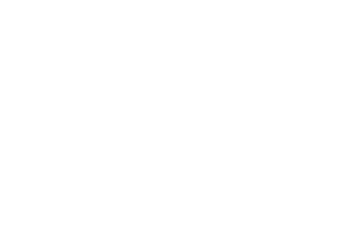

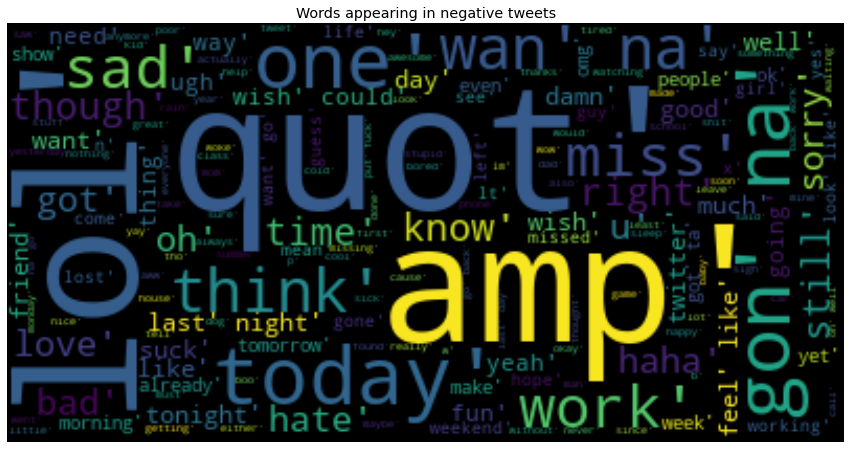

In [ ]:
plt.axis("off")
plt.figure(figsize=(15,8))
plt.tight_layout(pad=0)
plt.imshow(wordcloud_neg, interpolation='bilinear') # to make the displayed image appear more smoothly
plt.grid(None)
plt.savefig("Words appearing in negative tweets.png", dpi=100)
plt.axis('off')
plt.title("Words appearing in negative tweets")
plt.show()

In [ ]:
wordcloud_pos = WordCloud().generate(text_pos)

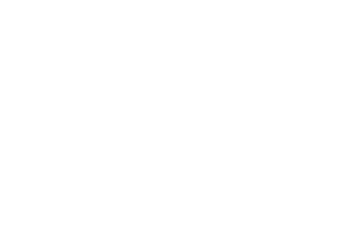

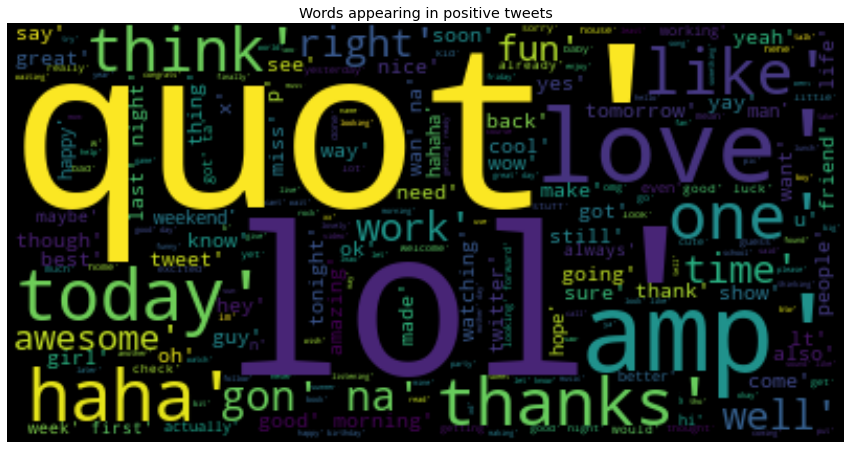

In [ ]:
plt.axis("off")
plt.figure(figsize=(15,8))
plt.tight_layout(pad=0)
plt.imshow(wordcloud_pos, interpolation='bilinear') # to make the displayed image appear more smoothly
plt.grid(None)
plt.savefig("Words appearing in positive tweets.png", dpi=100)
plt.axis('off')
plt.title("Words appearing in positive tweets")
plt.show()

In [ ]:
# applying stemming - I have applied Lemmatization above stemming because recognized to be a better methos 

# from nltk.stem import PorterStemmer

# ps = PorterStemmer()
# # for x in df.text:
# #   print(ps.stem(df.text[1][0]))

# for irow, row in df.iloc[:5,:].iterrows():
#   print(row)
#   print(row["text"])
#   new_list = []
#   for i in range(len(row["text"])):
#     x = ps.stem(row["text"][i])
#     new_list.append(x)
#   row["text"] = new_list
#   df.at[irow, "text"] = new_list

#   # print(new_list)

  
# # df.text = df.text.apply(lambda x: ps.stem(x))

In [48]:
# the tokenized words have been included in a dictionary as keywords, and values are unique numbers

make_tokens = Tokenizer(num_words = 500000) # (num_words = 50) limit word count to not allow words like : rodomontade, voyeurism, ostenation etc

make_tokens.fit_on_texts(df.text)

word_dict = make_tokens.word_index
print(len(word_dict))

545902


In [49]:
# sentences will be encoded - from word to numbers as in word_dict
encoded_sentences = make_tokens.texts_to_sequences(df.text)
encoded_sentences[0:3]

[[17513, 386, 1041, 3263, 7, 636, 8596, 1728, 1],
 [649, 283, 428, 1869, 196, 277, 1010, 72, 10, 177, 996],
 [24689, 74046, 218, 12, 822, 1537, 749, 360, 5, 2895]]

Issues :  
1) Broken sentences.  
2) Different encoded lengths.    
Solutions  
1) Need a large pre-prepared dictionary, OR use out of vocabolary token OOV  
2) Use padding  

In [50]:
# applying padding - OOV out-of-vocabulary
# Same approach as before but this time words not included in the most 60k frequent word will have keyword OOV and value 1

make_tokens = Tokenizer(num_words = 500000, oov_token= "<OOV>")
make_tokens.fit_on_texts(df.text)
word_dict = make_tokens.word_index

In [ ]:
# plotting lenght of sentences in df.text to pick right maxlen in padding and try to avoid an overfitting model

import seaborn as sns

# len(df.text[0])
new_list=[]
for i, row in df.iterrows():
  a =  len(row["text"])
  # if i == 5 : break
  # print(a)
  new_list.append(a)
  


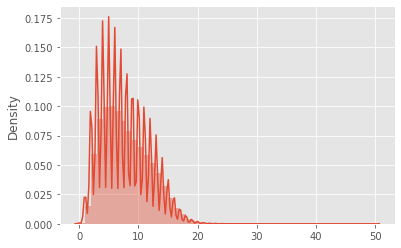

In [ ]:
sns.distplot(new_list)

In [51]:
# create consistent lenght of sentences using PADDING
# padding has been applied before, this parameter can be modified in the pad_sequence function with:
# padding= 'post'
# I could here import a maxlen as well for the encoded text
# chosen 15 as maxlen to include around 80% of sentences 

encoded_text = make_tokens.texts_to_sequences(df.text)
padded = pad_sequences(encoded_text, maxlen=15)
# print first record as example
print(encoded_text[0])
print(padded[0])

[17514, 387, 1042, 3264, 8, 637, 8597, 1729, 2]
[    0     0     0     0     0     0 17514   387  1042  3264     8   637
  8597  1729     2]


In [52]:
X = padded
y = df.label.to_list()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [54]:
X_train[0:5]

array([[     0,      0,      0,      0,      0,      0,    294,   9999,
          6808,    913,    204,     53,    201,     82,     11],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,    228,    214,    139,     51,   4765],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0, 147115,    392,     88,   7242,     54],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,     71,   5403,   1073,  25558, 170470],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 253908,    228,     12]],
      dtype=int32)

In [55]:
len(X_train[0])

15

In [56]:
X_test[0:5]

array([[    33,     19,     14,    163,   9663,  16899,    283,    270,
          6970,     18,    115, 169606,    647,    449,  13798],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,    154,   1907],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,   3830,    587,   3021,   2241,    103],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,   4235,   5388, 164157],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,   1580,   1580,   1580,    341,     11]],
      dtype=int32)

In [57]:
y_train[0:5]

[0, 1, 1, 0, 0]

In [58]:
X.shape

(1600000, 15)

**Word Embedding : representing words with vectors**  

Example of word embedding in 5 dimensions  
Male	Food	funny	respect	female  
King	.9	.04	.51	.95	.06  
Queen	.1	.03	.46	.96	.91  
Hen.	.04	.8.	.1.	.1	.94  
bad	.04	.1	.1	.1	.05  
Hello	.04	.05	.3	.8	.05  
prince	.93	.03	.48	.93	.05  
Words with similar meaning will be close to each other  
Neural networks can learn these vectors by training: it can learn the associated values.
NN also assigns abstract categories (dimensions)  

In [59]:
# embedding_dim parameter to be modified for better accuracy
vocab_size = 500000
embedding_dim = 100 # standard for high dataset
max_length = 15
trunc_type='post'
oov_tok = "<OOV>"

In [62]:
# machine or deep learning models accepts just data arrays and not list. converting train and test into arrays 

X_train =  np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [64]:
# I try now with a LSTM
# Applying dropout to overcome overfitting
model_lstm = tf.keras.Sequential([
    embedding_layer,
    # tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # tf.keras.layers.Flatten(), # not when using lstm or gru
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras. layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras. layers.Dropout(0.3),
    tf.keras.layers.Conv1D(128, 5 , activation = 'relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras. layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# I could use rmsprop instead of adam
model_lstm.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           50000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           84480     
_________________________________________________________________
dropout (Dropout)            (None, 15, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 15, 64)            41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 128)           41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0

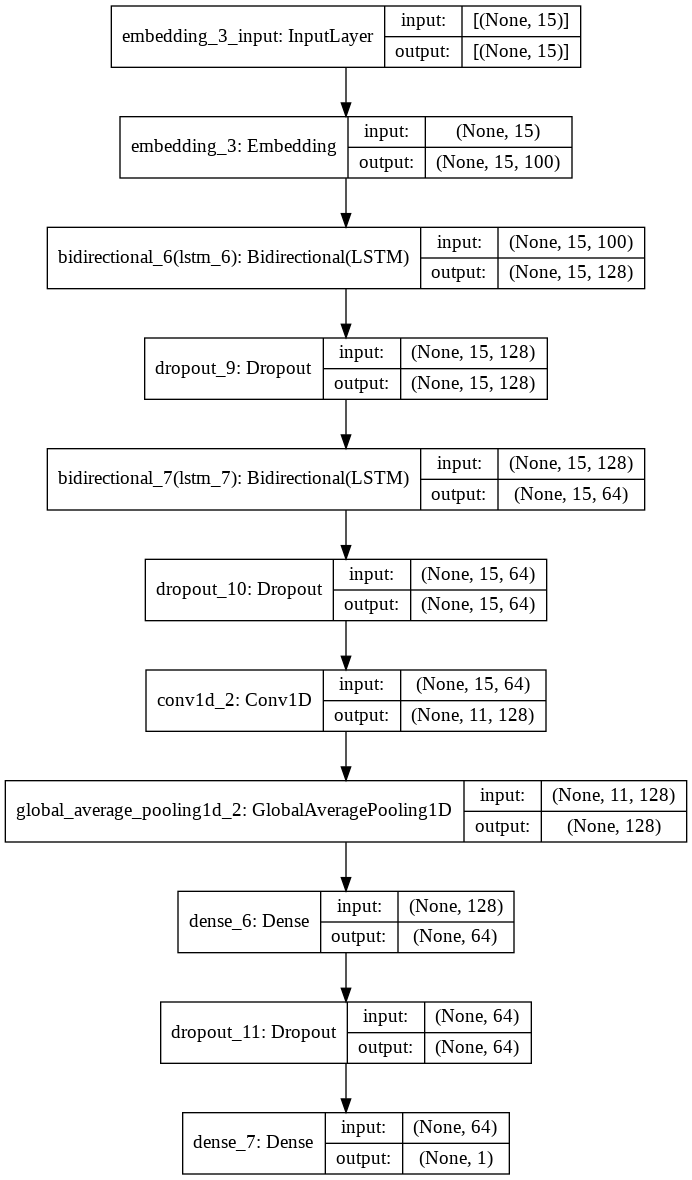

In [ ]:
# for visualising the model summary
tf.keras.utils.plot_model(model_lstm, show_shapes=True)

In [65]:
history_lstm = model_lstm.fit(X_train, y_train, epochs = 10,validation_split=0.25,batch_size = 1024)

Epoch 1/10
821/821 [==============================] - 195s 192ms/step - loss: 0.5034 - accuracy: 0.7481 - val_loss: 0.4483 - val_accuracy: 0.7869
Epoch 2/10
821/821 [==============================] - 153s 186ms/step - loss: 0.4286 - accuracy: 0.8021 - val_loss: 0.4431 - val_accuracy: 0.7905
Epoch 3/10
821/821 [==============================] - 155s 189ms/step - loss: 0.3924 - accuracy: 0.8257 - val_loss: 0.4670 - val_accuracy: 0.7811
Epoch 4/10
821/821 [==============================] - 155s 189ms/step - loss: 0.3429 - accuracy: 0.8541 - val_loss: 0.4887 - val_accuracy: 0.7723
Epoch 5/10
821/821 [==============================] - 155s 189ms/step - loss: 0.3024 - accuracy: 0.8737 - val_loss: 0.5253 - val_accuracy: 0.7576
Epoch 6/10
821/821 [==============================] - 155s 189ms/step - loss: 0.2740 - accuracy: 0.8865 - val_loss: 0.5377 - val_accuracy: 0.7648
Epoch 7/10
821/821 [==============================] - 155s 189ms/step - loss: 0.2549 - accuracy: 0.8949 - val_loss: 0.5486 -

In [67]:
df1 = pd.DataFrame(history_lstm.history)
df1

,loss,accuracy,val_loss,val_accuracy
0,0.474091,0.771618,0.448320,0.786861
1,0.428618,0.801985,0.443135,0.790518
2,0.391167,0.826305,0.466960,0.781114
3,0.343521,0.854174,0.488678,0.772318
4,0.306741,0.871811,0.525319,0.757564
5,0.281660,0.883092,0.537727,0.764789
6,0.262237,0.891662,0.548624,0.757900
7,0.246192,0.898489,0.584459,0.762557
8,0.231840,0.904665,0.673871,0.742214
9,0.218852,0.910677,0.669498,0.743339


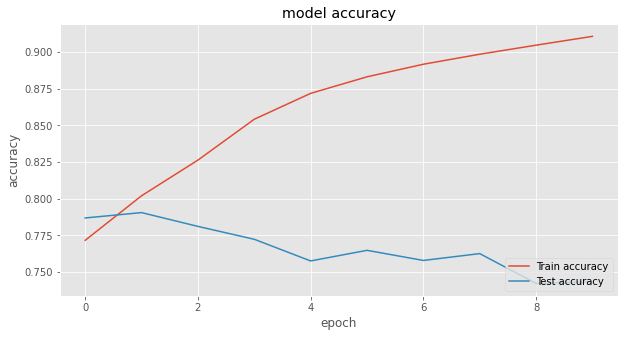

In [70]:
plt.figure(figsize=(10,5))
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()

In [68]:
history_lstm.history

{'accuracy': [0.7716178297996521,
  0.8019845485687256,
  0.8263047337532043,
  0.8541738390922546,
  0.8718107342720032,
  0.8830916881561279,
  0.8916618824005127,
  0.8984892964363098,
  0.904665470123291,
  0.9106773734092712],
 'loss': [0.4740905165672302,
  0.42861777544021606,
  0.3911670744419098,
  0.3435211181640625,
  0.3067406713962555,
  0.2816595733165741,
  0.2622367739677429,
  0.24619153141975403,
  0.2318403273820877,
  0.21885213255882263],
 'val_accuracy': [0.7868607044219971,
  0.7905178666114807,
  0.7811142802238464,
  0.7723178863525391,
  0.7575643062591553,
  0.7647892832756042,
  0.7578999996185303,
  0.7625571489334106,
  0.7422142624855042,
  0.7433393001556396],
 'val_loss': [0.4483201801776886,
  0.4431351125240326,
  0.4669603705406189,
  0.48867833614349365,
  0.5253190994262695,
  0.5377272963523865,
  0.5486235022544861,
  0.5844587683677673,
  0.6738714575767517,
  0.6694980263710022]}

In [69]:
history_lstm

In [ ]:
# acc. train data
# val. acc. accuracy of prediction on unsean data/test data

# prediction = model.predict(padded data)
# tf.greater(prediction, .5)

In [80]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('/content/gdrive/MyDrive/CAB/Data/glove_100d_6b.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))

word_list = list(word_dict.keys())[0:vocab_size]
for iword, word in enumerate(word_list):
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[iword] = embedding_vector
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)



In [81]:
model_lstm2 = tf.keras.Sequential([
    embedding_layer,
    # tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # tf.keras.layers.Flatten(), # not when using lstm or gru
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras. layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras. layers.Dropout(0.3),
    tf.keras.layers.Conv1D(128, 5 , activation = 'relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras. layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# I could use rmsprop instead of adam
model_lstm2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 100)           50000000  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 15, 256)           234496    
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 256)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 15, 128)           164352    
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 11, 128)           82048     
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)              

In [82]:
history_lstm2 = model_lstm2.fit(X_train, y_train, epochs = 10,validation_split=0.25,batch_size = 1024)

Epoch 1/10
821/821 [==============================] - 32s 33ms/step - loss: 0.6057 - accuracy: 0.6527 - val_loss: 0.5187 - val_accuracy: 0.7340
Epoch 2/10
821/821 [==============================] - 25s 31ms/step - loss: 0.5161 - accuracy: 0.7383 - val_loss: 0.4997 - val_accuracy: 0.7495
Epoch 3/10
821/821 [==============================] - 25s 31ms/step - loss: 0.4962 - accuracy: 0.7521 - val_loss: 0.4972 - val_accuracy: 0.7515
Epoch 4/10
821/821 [==============================] - 25s 31ms/step - loss: 0.4856 - accuracy: 0.7604 - val_loss: 0.4844 - val_accuracy: 0.7601
Epoch 5/10
821/821 [==============================] - 25s 31ms/step - loss: 0.4758 - accuracy: 0.7668 - val_loss: 0.4824 - val_accuracy: 0.7612
Epoch 6/10
821/821 [==============================] - 25s 31ms/step - loss: 0.4663 - accuracy: 0.7735 - val_loss: 0.4767 - val_accuracy: 0.7657
Epoch 7/10
821/821 [==============================] - 25s 31ms/step - loss: 0.4603 - accuracy: 0.7771 - val_loss: 0.4752 - val_accuracy:

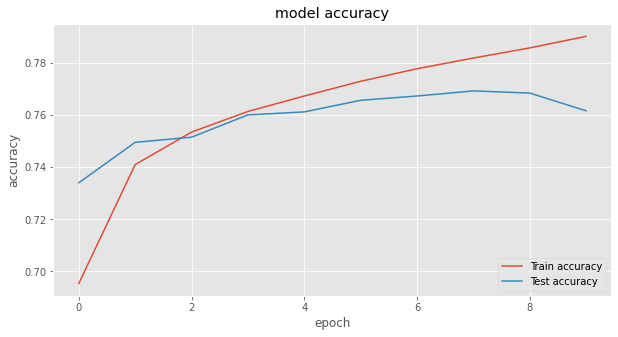

<Figure size 432x288 with 0 Axes>

In [93]:
plt.figure(figsize=(10,5))
plt.plot(history_lstm2.history['accuracy'])
plt.plot(history_lstm2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()
plt.savefig("Model Accuracy.png",dpi=100)

In [85]:
# getting prediction of the test data and then we will compare the true labels/classes of the data with predictions

y_pred = model_lstm2.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)


In [86]:
print(y_pred[:4])

[[False]
 [ True]
 [ True]
 [ True]]


Confusion matrix
These are the evaluation measures to evaluate the performance of the model.
Dark blue boxes are the correct predictions with the trained model and sky blue boxes shows the wrong predictions.



confusion matrix


[[162989  76733]
 [ 37749 202529]]




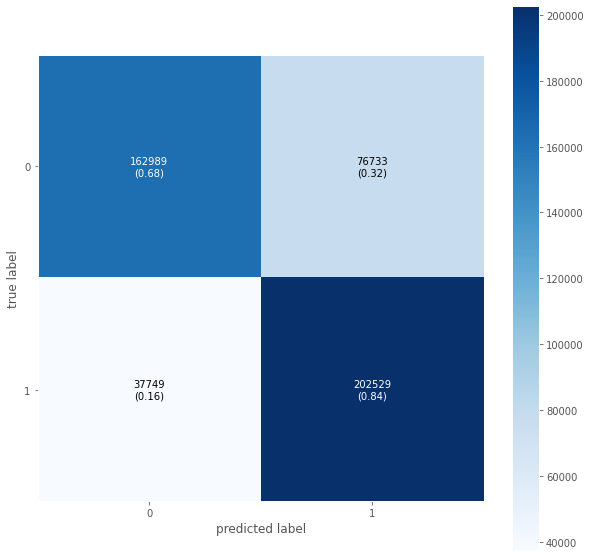

In [89]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
fig.savefig("Confusion Matrix.png",dpi=100)

ROC curve show the performance of the model. We can see that the model started from the 0 percent predictions and then moved to true positive predictions that are correct.
ROC curve (receiver operating characteristic curve) show the performance of a classification model at all the classification thresholds. ROC plots two parameters, True Positive Rate (correct predictions/classifications) False Positive Rate (wrong predictions/classifications)

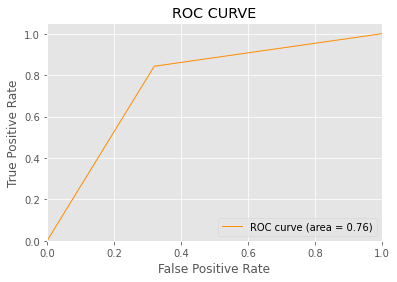

<Figure size 432x288 with 0 Axes>

In [92]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()
plt.savefig("Roc Curve.png",dpi=100)